# Amazon Product Review Dataset, Luxury Beauty

## Imports

In [1]:
import json
import pandas as pd
import numpy as np
#pip install gensim
from gensim.models import LdaMulticore, CoherenceModel
from gensim.parsing.preprocessing import preprocess_string, strip_numeric, strip_punctuation, remove_stopwords
from gensim.corpora import Dictionary as d
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim  
# pip install wordcloud
from wordcloud import WordCloud, STOPWORDS 
import seaborn as sns
%matplotlib inline

## Functions

### read in data

In [2]:
# function to turn a .json file into dataframe line by line
def dataframe_from_json(filename):
    data = []
    with open(filename) as f:
        for line in f:
            data.append(json.loads(line.strip()))
    df = pd.DataFrame.from_dict(data)
    return df

### preprocessing (goal is to have )

### unsupervised learning

In [12]:
def compute_coherence(model, texts, dictionary):
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    return coherence_lda


# exception to not start this if certain requirements (dictionary of weird characters) are met
def build_lda(seed, texts):
	#optional, in case data comes from a .csv:
    #texts = pd.read_csv(filename, names = colname ,converters = {'tweets': eval}, header = None, squeeze = True)
    #delete texts parameter accordingly
    dictionary = d(texts)
    print("-------------\n Output begins:")
    #remove words which appear <5 times in the dictionary + words which are more frequent than 10 per cent
    dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in texts]
    #change num_topics according to own interest
    lda_model = LdaMulticore(bow_corpus, random_state=seed, num_topics=5, id2word=dictionary, passes=2, workers=3, per_word_topics=True)
    print("----\nLDA results:\nshown here:")
    for idx, topic in lda_model.print_topics(-1):
       print('Topic: {} \nWords: {}'.format(idx, topic))
    #Compute Perplexity and Coherence

    perplexity = lda_model.log_perplexity(bow_corpus)
    coherence = compute_coherence(lda_model, texts, dictionary)
    print('\nPerplexity: ',perplexity, "\nCoherence:",coherence)
    print("---")


    return bow_corpus, dictionary, lda_model, coherence

def create_word_cloud(model):
    # more colors: 'mcolors.XKCD_COLORS'
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
#put title of the file as title of the graphics
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    

    #title = plt.title(title[-1])#right now this is shown as title instead of "topic 3".

    fname = 'Luxury_fashion_wordcloud.svg'

    plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w')
    plt.show()
    

def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()
    counter = 0
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                counter += 1
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                if counter%10000==0:
                    print('we are at {number:.{digits}f} per cent progress currently'.format(number=(counter/len(corpus))*100,digits=4))
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

def document_word_counts(dominant_topic):   #change to plotly for comparison
    print("Distribution of Document Word Counts by Dominant Topic")
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(2,2,figsize=(6,6), dpi=160, sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):    
        df_dominant_topic_sub = dominant_topic.loc[dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, bins = 80, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
        ax.set(xlim=(0, 80), xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.xticks(np.linspace(0,80,9))
    plt.show()

---

## Exploring the data

In [4]:
begin = pd.Timestamp.now()

#loading all .json pairs separately is recommended due to different file sizes and potentially long waits
in_luxury = dataframe_from_json('Luxury_Beauty.json')     #file size 285,2MB on disk

end = pd.Timestamp.now()

#printing the seconds from timedelta object between both times to check performance
print('It took {} seconds to execute this cell'.format(round((end-begin).total_seconds()),4))

It took 6 seconds to execute this cell


In [5]:
in_luxury.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2.0,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN
1,5.0,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN
2,5.0,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
3,5.0,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
4,5.0,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN


In [17]:
print(in_luxury[in_luxury['image'] != 'NaN'])

        overall vote  verified   reviewTime      reviewerID        asin  \
0           2.0    3      True  06 15, 2010  A1Q6MUU0B2ZDQG  B00004U9V2   
1           5.0   14      True   01 7, 2010  A3HO2SQDCZIE9S  B00004U9V2   
2           5.0  NaN      True  04 18, 2018  A2EM03F99X3RJZ  B00004U9V2   
3           5.0  NaN      True  04 18, 2018   A3Z74TDRGD0HU  B00004U9V2   
4           5.0  NaN      True  04 17, 2018  A2UXFNW9RTL4VM  B00004U9V2   
...         ...  ...       ...          ...             ...         ...   
574623      5.0  NaN      True  03 20, 2017   AHYJ78MVF4UQO  B01HIQEOLO   
574624      5.0  NaN      True  10 26, 2016  A1L2RT7KBNK02K  B01HIQEOLO   
574625      5.0  NaN      True  09 30, 2016  A36MLXQX9WPPW9  B01HIQEOLO   
574626      1.0    2      True   12 5, 2016  A23DRCOMC2RIXF  B01HJ2UY0W   
574627      5.0  NaN      True  01 14, 2017   AJEDVHTLS9P3V  B01HJ2UY1G   

           reviewerName                                         reviewText  \
0             D. Post

In [6]:
in_luxury['overall'].describe()

count    574628.000000
mean          4.225622
std           1.297522
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [6]:
review_score_counts = in_luxury['overall'].value_counts()

In [7]:
print(review_score_counts)

5.0    382152
4.0     70481
1.0     50501
3.0     41988
2.0     29506
Name: overall, dtype: int64


In [8]:
values = review_score_counts.tolist()

In [9]:
print(values)

[382152, 70481, 50501, 41988, 29506]


In [10]:
print(review_score_counts.index.tolist())

[5.0, 4.0, 1.0, 3.0, 2.0]


---

In [6]:
in_luxury.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574628 entries, 0 to 574627
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         574628 non-null  float64
 1   vote            103689 non-null  object 
 2   verified        574628 non-null  bool   
 3   reviewTime      574628 non-null  object 
 4   reviewerID      574628 non-null  object 
 5   asin            574628 non-null  object 
 6   reviewerName    574597 non-null  object 
 7   reviewText      574228 non-null  object 
 8   summary         574445 non-null  object 
 9   unixReviewTime  574628 non-null  int64  
 10  style           251013 non-null  object 
 11  image           7418 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 48.8+ MB


In [7]:
# define filters for the gensim preprocessor, see: https://radimrehurek.com/gensim/parsing/preprocessing.html
in_luxury['preprocessed_documents'] = in_luxury['reviewText'].apply(lambda x: preprocess_string(str(x)))

In [8]:
#in_luxury.drop('preprocessed_text', axis =1) #for dropping column if necessary

In [9]:
in_luxury.tail()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image,preprocessed_documents
574623,5.0,NaN,True,"03 20, 2017",AHYJ78MVF4UQO,B01HIQEOLO,Lori Fox,Great color and I prefer shellac over gel,Five Stars,1489968000,NaN,NaN,"[great, color, prefer, shellac, gel]"
574624,5.0,NaN,True,"10 26, 2016",A1L2RT7KBNK02K,B01HIQEOLO,Elena,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,1477440000,NaN,NaN,"[best, shellac, layer, nail, remov, easi, remov]"
574625,5.0,NaN,True,"09 30, 2016",A36MLXQX9WPPW9,B01HIQEOLO,Donna D. Harris,Great polish and beautiful color!!,Great polish!,1475193600,NaN,NaN,"[great, polish, beauti, color]"
574626,1.0,2,True,"12 5, 2016",A23DRCOMC2RIXF,B01HJ2UY0W,Y.Y. Chen,"The perfume is good, but the spray head broke ...",Spray head broke off within a month,1480896000,"{'Size:': ' 1.7 Fluid Ounce', 'Color:': ' Multi'}",NaN,"[perfum, good, sprai, head, broke]"
574627,5.0,NaN,True,"01 14, 2017",AJEDVHTLS9P3V,B01HJ2UY1G,ML Shelton,Great fragrance.,Five Stars,1484352000,"{'Size:': ' 3.4 Fluid Ounce', 'Color:': ' Multi'}",NaN,"[great, fragranc]"


In [20]:
in_luxury.tail(10)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
574618,5.0,NaN,True,"11 30, 2017",AGC1Z5C1NQ64A,B01HIQEOLO,Marianela Baeza Fallas,Excellent,Five Stars,1512000000,NaN,NaN
574619,5.0,NaN,True,"07 19, 2017",A1MF2O7B7HG5TT,B01HIQEOLO,Amazon Customer,Product received as expected. Prompt shipment.,Five Stars,1500422400,NaN,NaN
574620,5.0,NaN,True,"06 16, 2017",A1DM2ONVGHF881,B01HIQEOLO,magsrn,Awesome color!,Five Stars,1497571200,NaN,NaN
574621,5.0,NaN,True,"04 22, 2017",A1Z8ZP55SRLZM9,B01HIQEOLO,Shopper,Love CND shellac. Nice color,Great product,1492819200,NaN,NaN
574622,5.0,NaN,True,"03 27, 2017",A1OTTRGOQI1BV,B01HIQEOLO,Kate Erickson,Nice color!,Five Stars,1490572800,NaN,NaN
574623,5.0,NaN,True,"03 20, 2017",AHYJ78MVF4UQO,B01HIQEOLO,Lori Fox,Great color and I prefer shellac over gel,Five Stars,1489968000,NaN,NaN
574624,5.0,NaN,True,"10 26, 2016",A1L2RT7KBNK02K,B01HIQEOLO,Elena,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,1477440000,NaN,NaN
574625,5.0,NaN,True,"09 30, 2016",A36MLXQX9WPPW9,B01HIQEOLO,Donna D. Harris,Great polish and beautiful color!!,Great polish!,1475193600,NaN,NaN
574626,1.0,2,True,"12 5, 2016",A23DRCOMC2RIXF,B01HJ2UY0W,Y.Y. Chen,"The perfume is good, but the spray head broke ...",Spray head broke off within a month,1480896000,"{'Size:': ' 1.7 Fluid Ounce', 'Color:': ' Multi'}",NaN
574627,5.0,NaN,True,"01 14, 2017",AJEDVHTLS9P3V,B01HJ2UY1G,ML Shelton,Great fragrance.,Five Stars,1484352000,"{'Size:': ' 3.4 Fluid Ounce', 'Color:': ' Multi'}",NaN


In [22]:
word_count = 0
for row in in_luxury['reviewText']:
    if 'amazon' in str(row):
        word_count += 1
    else:
        pass

In [23]:
print('a total of {} times we find the word "amazon" in the dataframe'.format(word_count))

a total of 3256 times we find the word "amazon" in the dataframe


now our new column "preprocessed_text" contains nice tokens

#### optional: removing short tokens such as 't'

In [10]:
corpus = in_luxury['preprocessed_documents'].to_list()

## throwing the text into the topic model:

In [11]:
new_corpus, dictionary, lda_model, coherence = build_lda(42,corpus)

-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.022*"face" + 0.012*"cream" + 0.008*"week" + 0.008*"shave" + 0.008*"ey" + 0.008*"dai" + 0.008*"help" + 0.007*"differ" + 0.007*"notic" + 0.007*"sensit"
Topic: 1 
Words: 0.027*"scent" + 0.016*"nice" + 0.014*"leav" + 0.013*"dry" + 0.013*"moistur" + 0.013*"soft" + 0.012*"best" + 0.011*"stuff" + 0.011*"fragranc" + 0.011*"shampoo"
Topic: 2 
Words: 0.010*"curl" + 0.009*"bui" + 0.009*"purchas" + 0.009*"bottl" + 0.008*"price" + 0.008*"hold" + 0.008*"year" + 0.007*"brush" + 0.007*"bought" + 0.007*"amazon"
Topic: 3 
Words: 0.048*"color" + 0.015*"appli" + 0.013*"nail" + 0.011*"polish" + 0.011*"dai" + 0.009*"makeup" + 0.009*"ey" + 0.008*"foundat" + 0.008*"nice" + 0.008*"mascara"

Perplexity:  -7.167061547031757 
Coherence: 0.5414397131566058
---


maybe remove 'amazon' as a custom stop word in the future.

## building some vizzes:

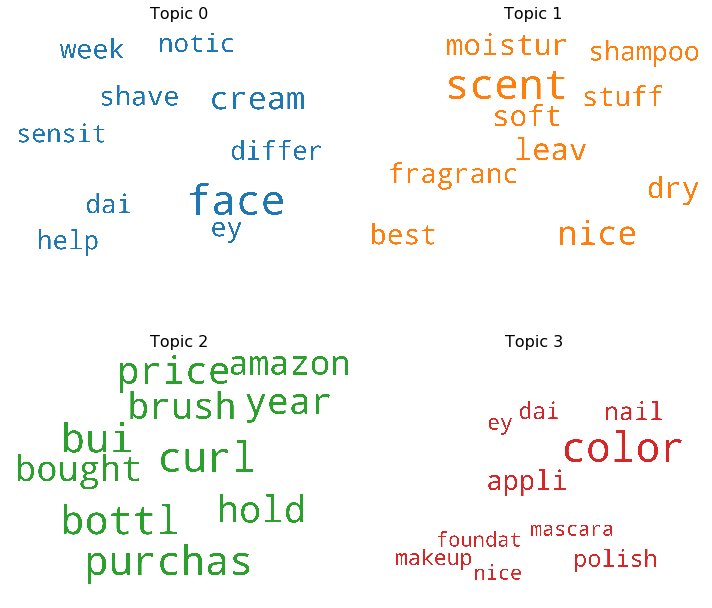

In [12]:
create_word_cloud(lda_model)

again, this is nice for removal of stop words in the future :D

In [13]:
ldavis = pyLDAvis.gensim.prepare(lda_model, new_corpus, dictionary)

In [14]:
pyLDAvis.enable_notebook()
pyLDAvis.display(ldavis)

topic 1(0) and 2(1) seem to overlap still...

In [17]:
print(new_corpus[0])

[(0, 1), (1, 2), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1)]


In [23]:
print(len(new_corpus))

574628


In [24]:
print(len(corpus))

574628


In [32]:
#progress print
print('we are at {number:.{digits}f} per cent progress currently'.format(number=(30000/len(corpus))*100,digits=4))

we are at 5.2208 per cent progress currently


## Retrieving dominant topics

In [35]:
df_topic_sents_keywords = format_topics_sentences(lda_model,new_corpus,corpus)

we are at 1.7403 per cent progress currently
we are at 3.4805 per cent progress currently
we are at 5.2208 per cent progress currently
we are at 6.9610 per cent progress currently
we are at 8.7013 per cent progress currently
we are at 10.4415 per cent progress currently
we are at 12.1818 per cent progress currently
we are at 13.9221 per cent progress currently
we are at 15.6623 per cent progress currently
we are at 17.4026 per cent progress currently
we are at 19.1428 per cent progress currently
we are at 20.8831 per cent progress currently
we are at 22.6233 per cent progress currently
we are at 24.3636 per cent progress currently
we are at 26.1038 per cent progress currently
we are at 27.8441 per cent progress currently
we are at 29.5844 per cent progress currently
we are at 31.3246 per cent progress currently
we are at 33.0649 per cent progress currently
we are at 34.8051 per cent progress currently
we are at 36.5454 per cent progress currently
we are at 38.2856 per cent progress cur

In [36]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

## show per document statistics about words

Distribution of Document Word Counts by Dominant Topic


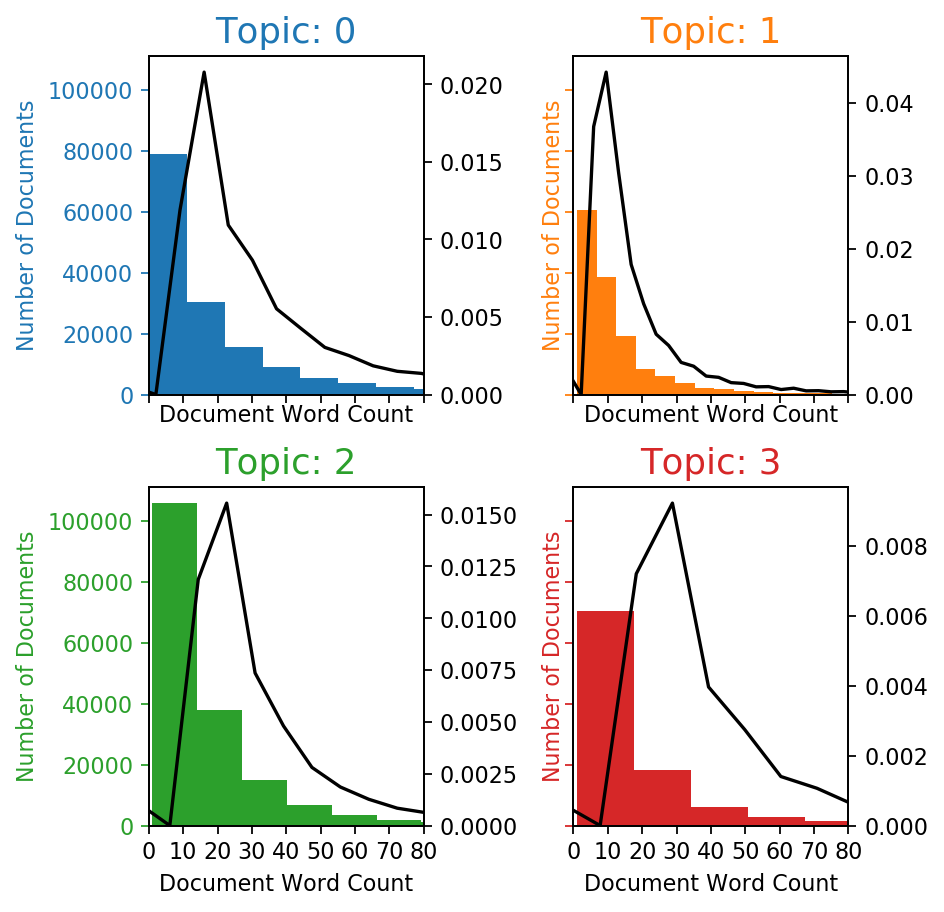

In [39]:
document_word_counts(df_dominant_topic)

In [40]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3971,"scent, nice, leav, dry, moistur, soft, best, s...","[bought, hand, cream, dispens, work, hand, cre..."
1,1,1.0,0.8460,"scent, nice, leav, dry, moistur, soft, best, s...","[believ, year, tri, differ, hand, cream, peopl..."
2,2,1.0,0.7481,"scent, nice, leav, dry, moistur, soft, best, s...","[great, hand, lotion]"
3,3,1.0,0.5799,"scent, nice, leav, dry, moistur, soft, best, s...","[best, sever, dry, skin, hand]"
4,4,1.0,0.6114,"scent, nice, leav, dry, moistur, soft, best, s...","[best, non, oili, hand, cream, heal, overnight]"


In [42]:
df_dominant_topic.tail()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
574623,574623,3.0,0.8446,"color, appli, nail, polish, dai, makeup, ey, f...","[great, color, prefer, shellac, gel]"
574624,574624,3.0,0.9042,"color, appli, nail, polish, dai, makeup, ey, f...","[best, shellac, layer, nail, remov, easi, remov]"
574625,574625,3.0,0.8116,"color, appli, nail, polish, dai, makeup, ey, f...","[great, polish, beauti, color]"
574626,574626,2.0,0.5683,"curl, bui, purchas, bottl, price, hold, year, ...","[perfum, good, sprai, head, broke]"
574627,574627,1.0,0.6250,"scent, nice, leav, dry, moistur, soft, best, s...","[great, fragranc]"


In [41]:
df_dominant_topic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574628 entries, 0 to 574627
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Document_No         574628 non-null  int64  
 1   Dominant_Topic      574628 non-null  float64
 2   Topic_Perc_Contrib  574628 non-null  float64
 3   Keywords            574628 non-null  object 
 4   Text                574628 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 21.9+ MB


In [ ]:
df_dominant_topic['word_length']

In [43]:
#adding the topic column to our existing dataframe
in_luxury['topic'] = df_dominant_topic['Dominant_Topic']

## New DataFrame with added column "topic"

In [44]:
in_luxury.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image,preprocessed_documents,topic
0,2.0,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN,"[bought, hand, cream, dispens, work, hand, cre...",1.0
1,5.0,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN,"[believ, year, tri, differ, hand, cream, peopl...",1.0
2,5.0,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN,"[great, hand, lotion]",1.0
3,5.0,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN,"[best, sever, dry, skin, hand]",1.0
4,5.0,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN,"[best, non, oili, hand, cream, heal, overnight]",1.0


---